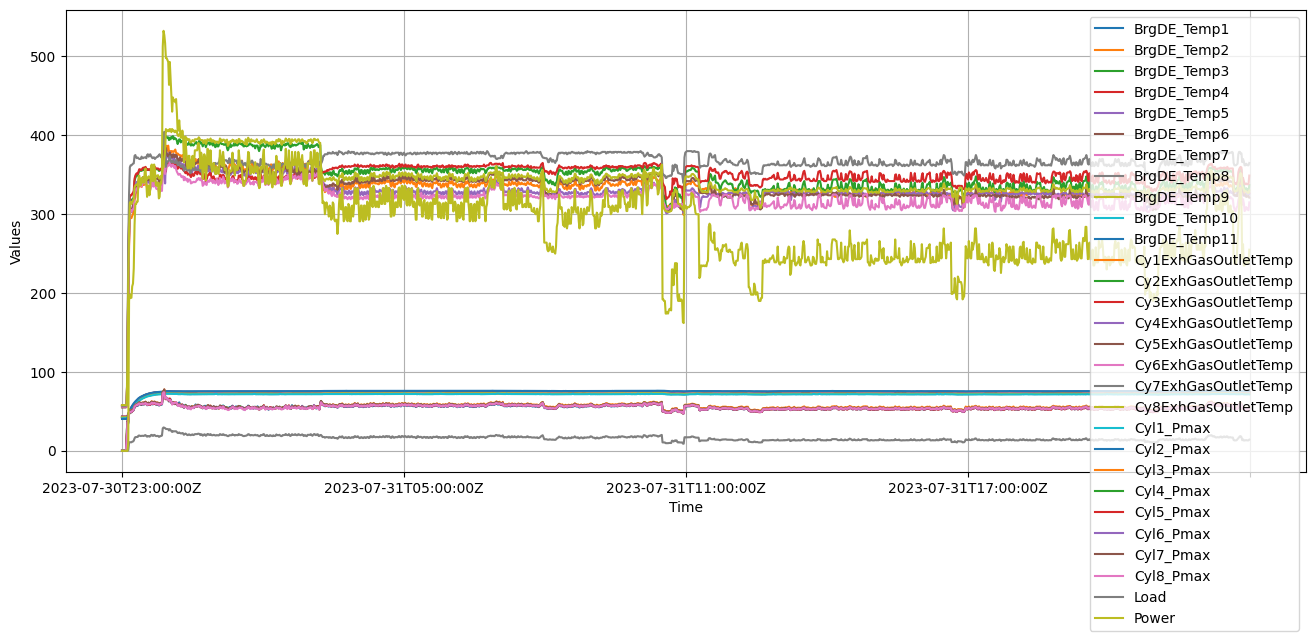

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from influxdb import InfluxDBClient

# Connect to InfluxDB and fetch data
client = InfluxDBClient(host='localhost', port=8086)
client.switch_database('ISS')

# Define the time range for the data retrieval
start_time = '2023-07-30T23:00:00Z'
end_time = '2023-07-31T23:00:00Z'

# Define the queries
query_dg2 = f'SELECT * FROM "DG2Thing_HMD8310" WHERE time >= \'{start_time}\' AND time < \'{end_time}\''
query_de2 = f'SELECT * FROM "DE2Thing_HMD8310" WHERE time >= \'{start_time}\' AND time < \'{end_time}\''

# Fetch data for DG2 and DE2
results_dg2 = client.query(query_dg2)
results_de2 = client.query(query_de2)

# Create DataFrames for DG2 and DE2 data
df_train_dg2 = pd.DataFrame.from_records(results_dg2.get_points())
df_train_de2 = pd.DataFrame.from_records(results_de2.get_points())

# Create a list to store columns to include in the combined DataFrame
columns_to_include = []

# Convert BrgDE_Temp1 to BrgDE_Temp11 columns to numeric for DG2
for i in range(1, 12):
    col_name = f'BrgDE_Temp{i}'
    df_train_dg2[col_name] = pd.to_numeric(df_train_dg2[col_name])
    columns_to_include.append(col_name)

# Convert relevant columns to numeric for DE2
for i in range(1, 9):
    col_name = f'Cy{i}ExhGasOutletTemp'
    df_train_de2[col_name] = pd.to_numeric(df_train_de2[col_name])
    columns_to_include.append(col_name)

for i in range(1, 9):
    col_name = f'Cyl{i}_Pmax'
    df_train_de2[col_name] = pd.to_numeric(df_train_de2[col_name])
    columns_to_include.append(col_name)

col_name = 'Load'
df_train_de2[col_name] = pd.to_numeric(df_train_de2[col_name])
columns_to_include.append(col_name)

col_name = 'Power'
df_train_de2[col_name] = pd.to_numeric(df_train_de2[col_name])
columns_to_include.append(col_name)

# Combine the two DataFrames by merging on the 'time' column
combined_df = pd.merge(df_train_dg2, df_train_de2, on='time')

# Set up the plot
fig, ax_train = plt.subplots(figsize=(16, 6))

# Plot selected columns
for col_name in columns_to_include:
    ax_train.plot(combined_df['time'], combined_df[col_name], label=col_name, linestyle='-')

# Set x-axis ticks and grid
total_len = len(combined_df.index)
ax_train.set_xticks(np.arange(0, total_len + 1, total_len / 4))
ax_train.grid(True)

# Set labels and legend
ax_train.set_xlabel('Time')
ax_train.set_ylabel('Values')
ax_train.legend()

# Show the plot
plt.show()


total_count : 60


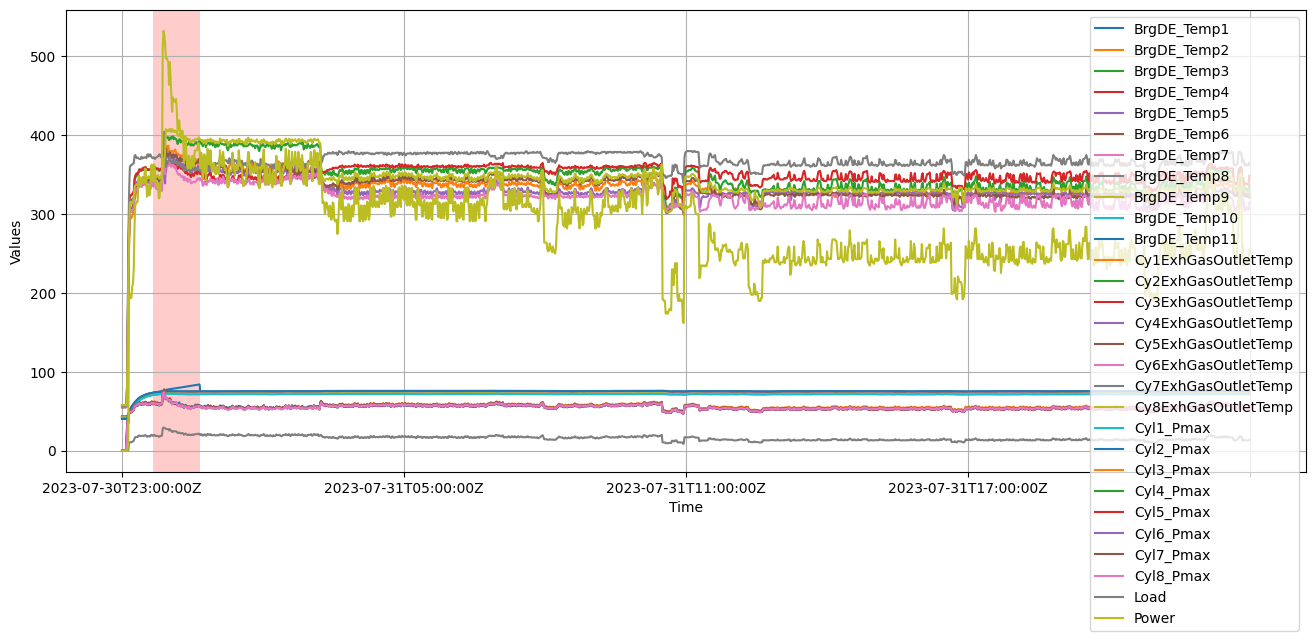

In [68]:
# Manipulate the 'BrgDE_Temp1' data gradually
start_manipulation_time = '2023-07-30T23:40:00Z'  # Start manipulation time
end_manipulation_time = '2023-07-31T00:40:00Z'  # End manipulation time
modify_data = 'BrgDE_Temp1'

# Find the indices corresponding to the start and end times
start_index = combined_df[combined_df['time'] == start_manipulation_time].index[0]
end_index = combined_df[combined_df['time'] == end_manipulation_time].index[0]

# Calculate the increment based on +10 divided by the total count of data to be modified
total_count = end_index - start_index
increment = 10 / total_count
delta = increment

# Gradually add +10 to the 'BrgDE_Temp1' values in increments
for i in range(start_index, end_index):
    combined_df.at[i, modify_data] += delta
    delta = delta + increment

# Create a plot with the specified size
fig, ax_train = plt.subplots(figsize=(16, 6))

# Plot selected columns
for col_name in columns_to_include:
    ax_train.plot(combined_df['time'], combined_df[col_name], label=col_name, linestyle='-')

# Set x-axis ticks and grid
total_len = len(combined_df.index)
ax_train.set_xticks(np.arange(0, total_len + 1, total_len / 4))
ax_train.grid(True)

# Set labels and legend
ax_train.set_xlabel('Time')
ax_train.set_ylabel('Values')
ax_train.legend()

# Find the indices corresponding to the start and end times
start_index = combined_df[combined_df['time'] == start_manipulation_time].index[0]
end_index = combined_df[combined_df['time'] == end_manipulation_time].index[0]

# Calculate the increment based on +10 divided by the total count of data to be modified
total_count = end_index - start_index
increment = 10 / total_count
delta = increment
print("total_count : " + str(total_count))

# Gradually add +10 to the 'BrgDE_Temp1' values in increments
for i in range(start_index, end_index):
    combined_df.at[i, modify_data] += delta
    delta = delta + increment

# Create a shaded region on the plot background
ax_train.axvspan(
    combined_df['time'][start_index],
    combined_df['time'][end_index],
    facecolor='red',
    alpha=0.2,
)

# Show the plot
plt.show()

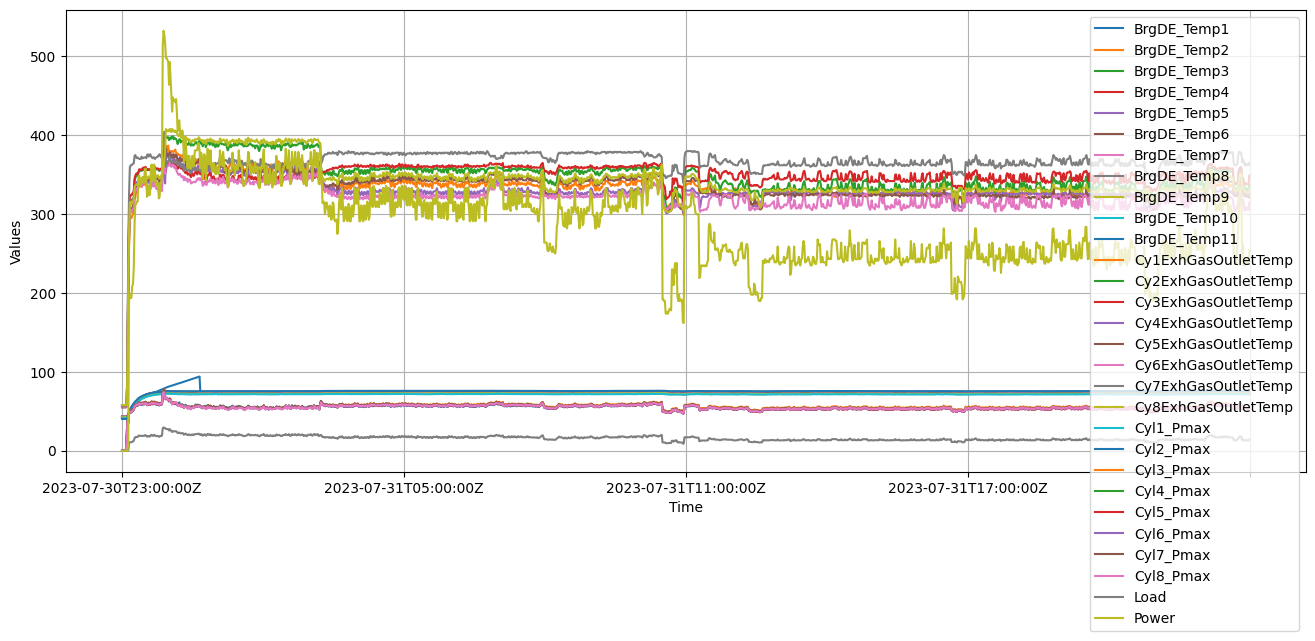

In [69]:
# Convert the combined and modified DataFrame back to InfluxDB data
json_body = []

for index, row in combined_df.iterrows():
    data_fields = {}
    for col_name in columns_to_include:
        data_fields[col_name] = row[col_name]

    json_body.append({
        "measurement": "ModifiedData",  # New measurement name
        "tags": {},
        "time": row['time'],
        "fields": data_fields
    })

# Write the modified and combined data to the "ModifiedData" measurement in InfluxDB
client.write_points(json_body)

# Read the modified and combined data from InfluxDB
results_modified = client.query(f'SELECT * FROM "ModifiedData" WHERE time >= \'{start_time}\' AND time < \'{end_time}\'')
df_modified = pd.DataFrame.from_records(results_modified.get_points())

# Set up the plot for the modified and combined data
fig, ax_train = plt.subplots(figsize=(16, 6))

# Plot all relevant columns
for col_name in columns_to_include:
    ax_train.plot(df_modified['time'], df_modified[col_name], label=col_name, linestyle='-')

# Set x-axis ticks and grid
total_len = len(df_modified.index)
ax_train.set_xticks(np.arange(0, total_len + 1, total_len / 4))
ax_train.grid(True)

# Set labels and legend
ax_train.set_xlabel('Time')
ax_train.set_ylabel('Values')
ax_train.legend()

# Show the plot for the modified and combined data
plt.show()
